# Relaxed Solver for Dynamic Unbalanced Optimal Transport

In this notebook, we check the behavior of `dynamic_wfr_relaxed_grid` function which solves the unbalanced dynamic OT problem on a rectangular grid.

In [1]:
# Import relevant libraries
import sys
import torch
sys.path.append('../relaxed')
from dynamic_wfr_relaxed import dynamic_wfr_relaxed_grid, dynamic_wfr_relaxed_grid_scipy
import numpy as np
import matplotlib.pyplot as plt

## Example 1: Scaling of the uniform distribution

Expected solution:
$\begin{align} \textrm{WFR}_1 &= \sqrt{2} \tag*{} \\ \rho &= (t+1)^2 \rho_0 \otimes dt \tag*{} \end{align}$


We first calculate the solution using SGD.

WFR distance: tensor(1.3125)


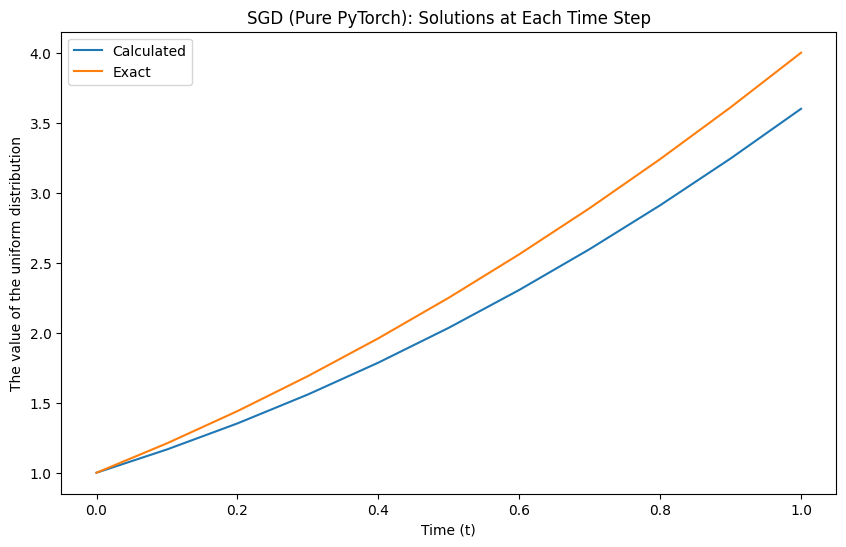

In [12]:
T = 10
N = 10
p1 = torch.ones(N)
p2 = 4*p1

wfr, p, v, z = dynamic_wfr_relaxed_grid(p1, p2, delta=1, rel=70, T=T, lr=1e-3)

print('WFR distance:', wfr)

# Convert the tensor to a NumPy array
data = p.numpy()

# Create the spatial grid
t = np.linspace(0, 1, T+1)  # Spatial points

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, (t+1)**2, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('SGD (Pure PyTorch): Solutions at Each Time Step')
plt.legend()
plt.show()

We note that there are `rel`s that gives the better results than the above. We use the same `rel` as below for comparison.

We now do the same using the scipy LBFGS. 

WFR distance: 1.4647174723824161


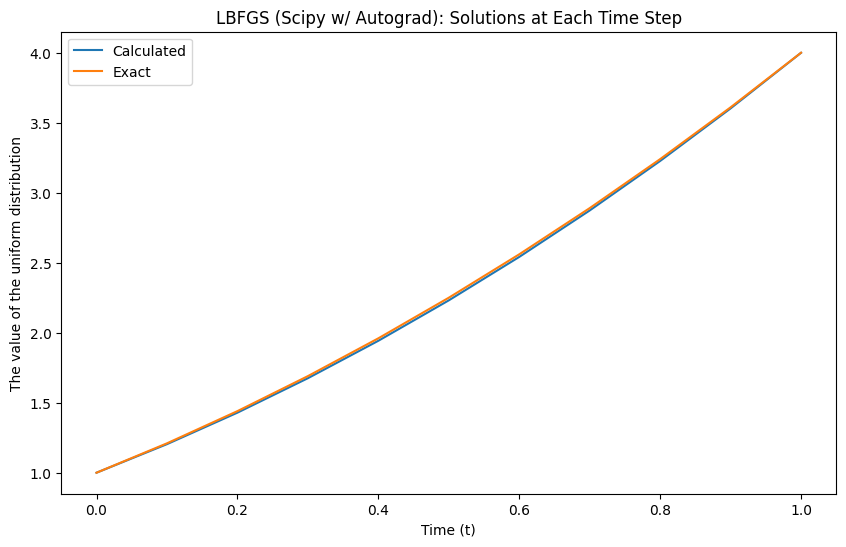

In [11]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

wfr, p, v, z = dynamic_wfr_relaxed_grid_scipy(p1,
                                              p2, 
                                              delta=1, 
                                              rel=70, 
                                              T=T)

print('WFR distance:', wfr)

# Convert the tensor to a NumPy array

# Create the spatial grid
t = np.linspace(0, 1, T+1)  # Spatial points

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(t, p[:, 0], label = 'Calculated')
plt.plot(t, (t+1)**2, label = 'Exact')

plt.xlabel('Time (t)')
plt.ylabel('The value of the uniform distribution')
plt.title('LBFGS (Scipy w/ Autograd): Solutions at Each Time Step')
plt.legend()
plt.show()

We will now investigate how we can tune the `rel` parameter. We gradually increase the `rel` parameter from 1 to 100 and see how the error between the exact solution changes.

91


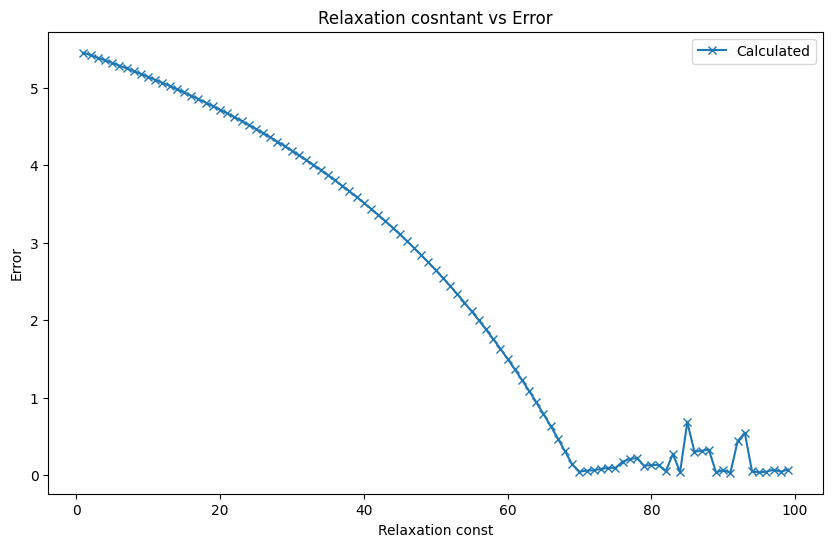

In [4]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100, 1)
error = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

for rel in rels:
    wfr, p, v, z = dynamic_wfr_relaxed_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    error.append(np.linalg.norm(p[:, 0]-exact))

min_ind = np.argmin(error)
print(rels[min_ind])

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, error, label = 'Calculated', marker='x')

plt.xlabel('Relaxation const')
plt.ylabel('Error')
plt.title('Relaxation cosntant vs Error')
plt.legend()
plt.show()

We note that the error monotonically decreases until it reaches the plateau, and then it oscilates. We will now see if we can observe the same phenomenon without using the exact solution. We plot the calculated WFR distance against the relaxation parameter.

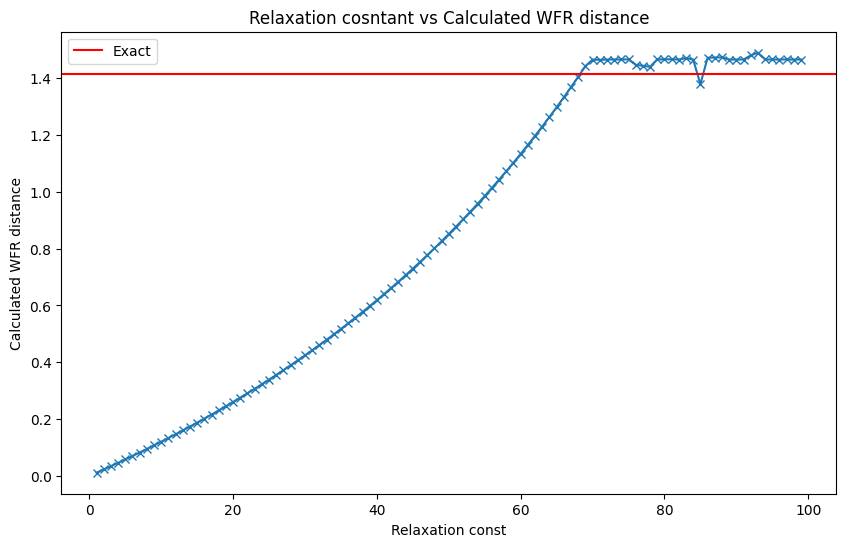

In [13]:
T = 10
N = 10
p1 = np.ones(N)
p2 = 4*p1

rels = np.arange(1,100,1)
wfrs = []

t = np.linspace(0, 1, T+1)
exact = (t+1)**2

for rel in rels:
    wfr, p, v, z = dynamic_wfr_relaxed_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')
plt.axhline(y=np.sqrt(2), color='r', linestyle='-', label = 'Exact')

plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR distance')
plt.title('Relaxation cosntant vs Calculated WFR distance')
plt.legend()
plt.show()

We observe the same phenomenon with a quantity that does not require the outside knowledge. We can establish the tuning strategy from this. Namely, we increase the parameter until the calculated WFR stops increasing.

## Example 2: Translation of von-Mises distribution

The von-Mises distribution is a continuous distribution on $[0,2\pi]$ defined by the pdf

$\begin{equation} f(x|\mu,\kappa) = \frac{\exp(\kappa \cos(x-\mu))}{2\pi I_0(\kappa)}\end{equation}\tag*{}$

where $I_0(\kappa)$ is the modifed Bessel function of the first kind of order 0. This is often referred to as the normal distribution on a circle.

We first check if the WFR plateau also appears in this case.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


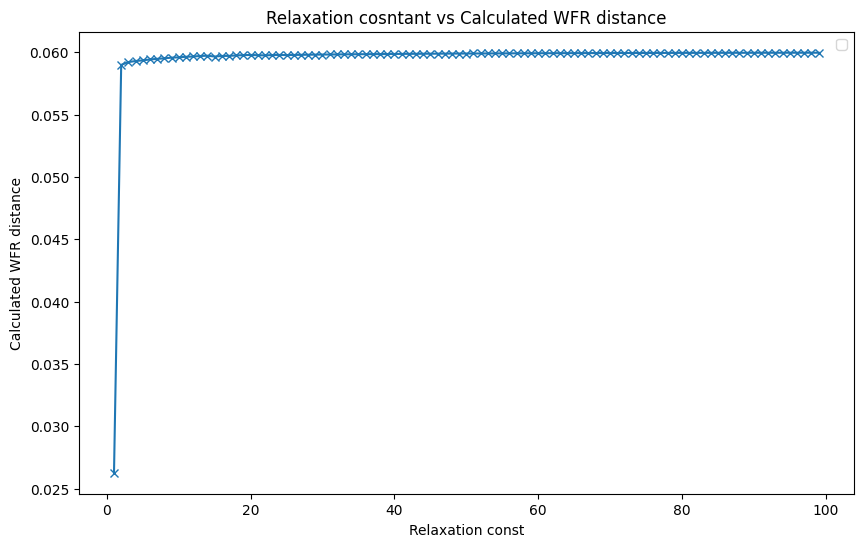

In [20]:
from scipy.special import i0
def von_mises_pdf(x, mu, k):
    return np.exp(k*np.cos(x-mu))/(2*np.pi*i0(k))

T = 10
N = 10

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = np.roll(p1, 5)

rels = np.arange(1,100,1)
wfrs = []

for rel in rels:
    wfr, p, v, z = dynamic_wfr_relaxed_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')

plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR distance')
plt.title('Relaxation cosntant vs Calculated WFR distance')
plt.legend()
plt.show()

We note that the plateau appears much earlier. We will try with the smaller range.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


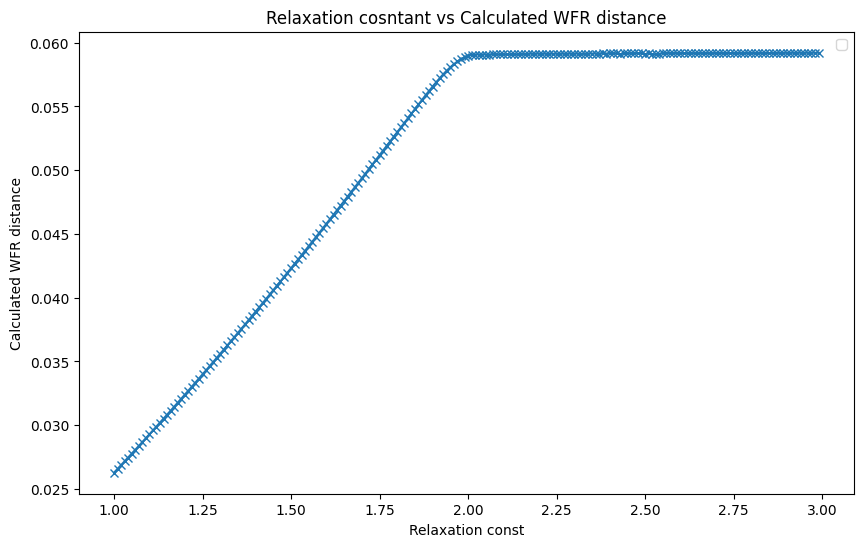

In [23]:
rels = np.arange(1,3, 0.01)
wfrs = []

for rel in rels:
    wfr, p, v, z = dynamic_wfr_relaxed_grid_scipy(p1, p2, delta=1, rel=rel, T=T)
    wfrs.append(float(wfr))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(rels, wfrs, marker = 'x')

plt.xlabel('Relaxation const')
plt.ylabel('Calculated WFR distance')
plt.title('Relaxation cosntant vs Calculated WFR distance')
plt.legend()
plt.show()

Again we observe the plateau. We will now plot the solution at each time for `rel`=2.

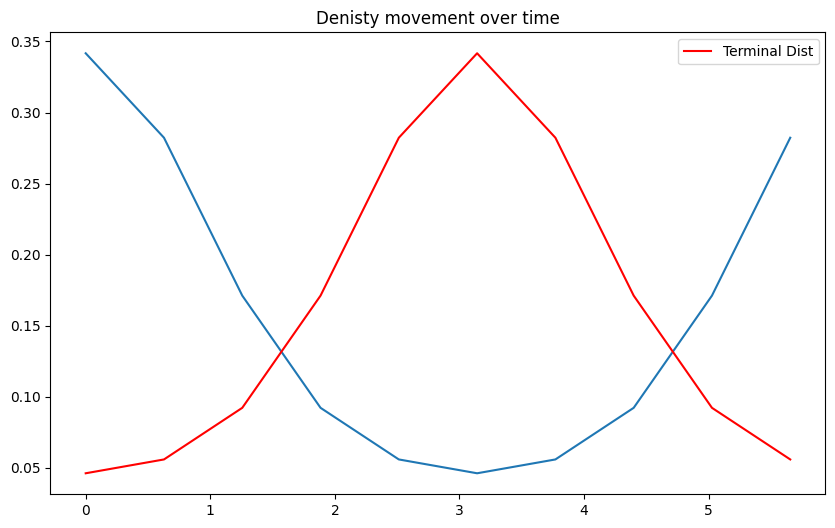

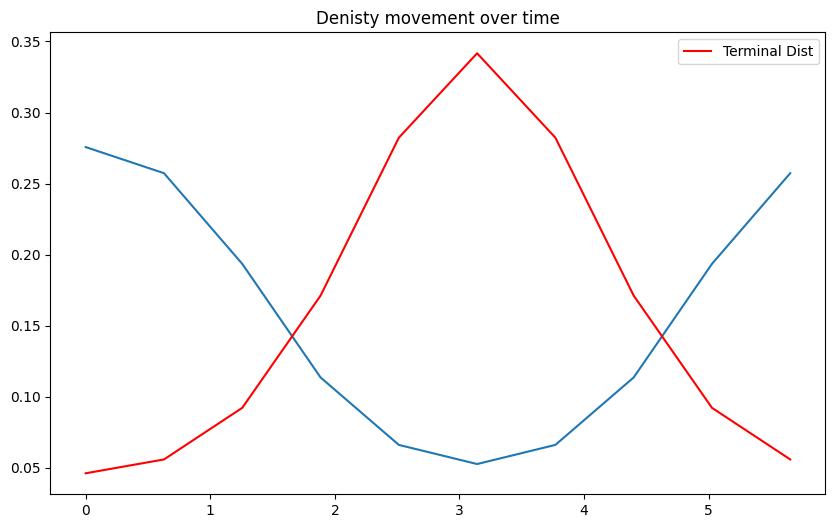

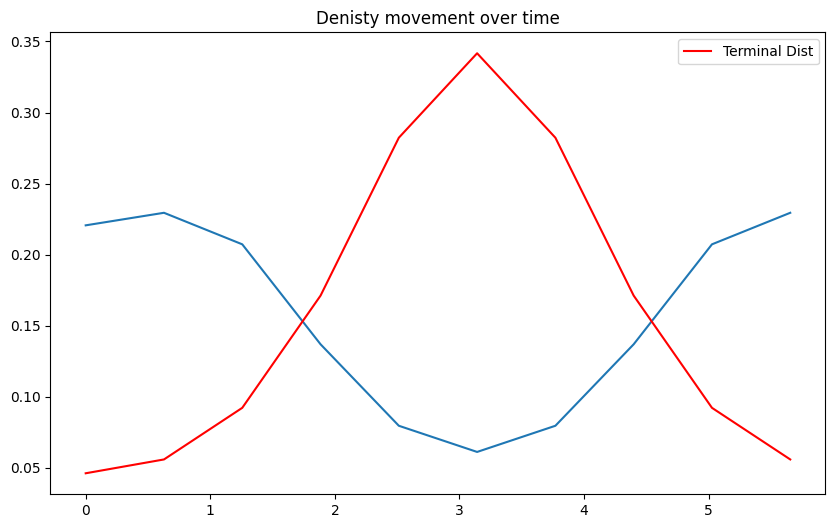

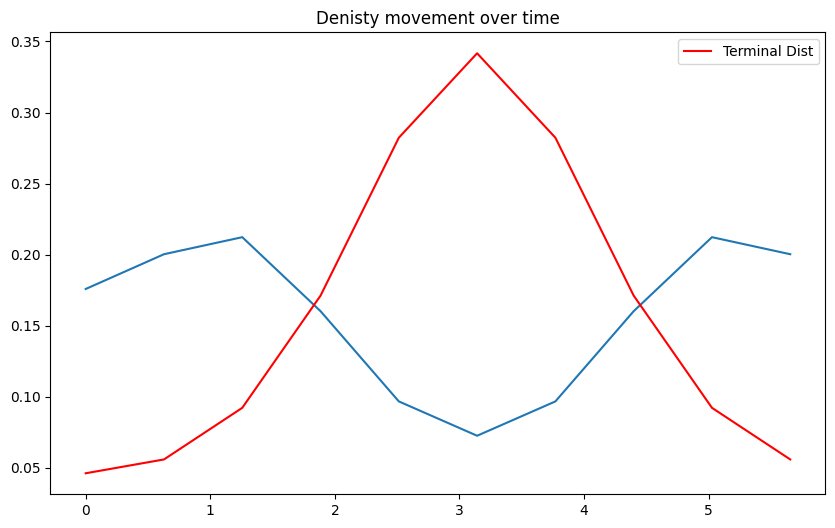

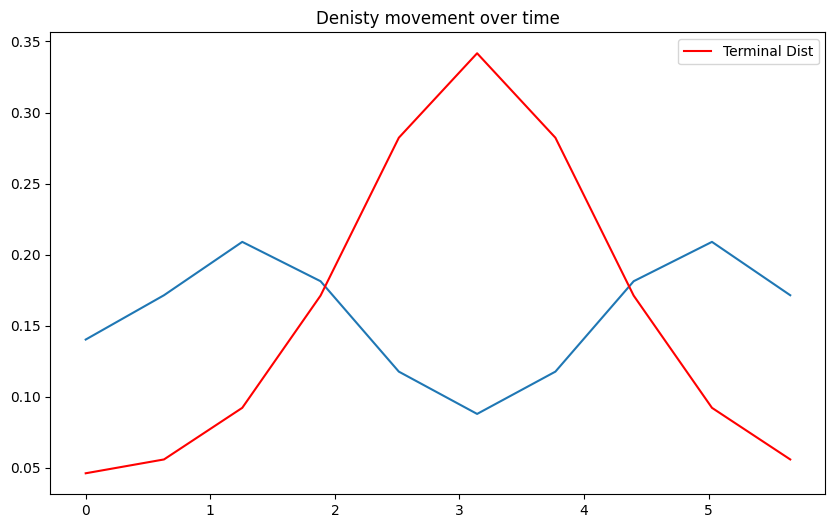

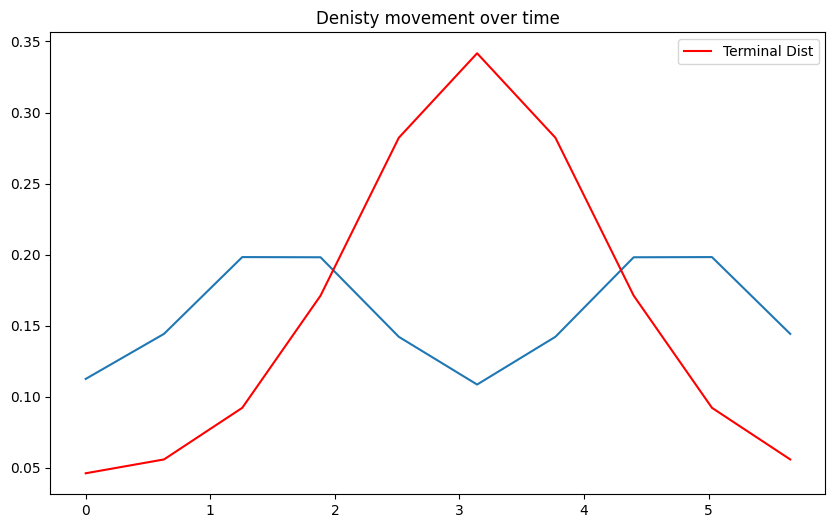

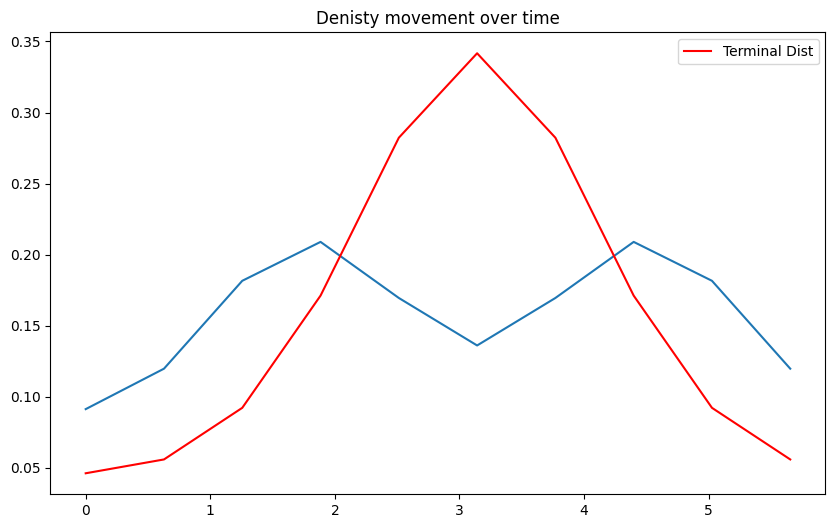

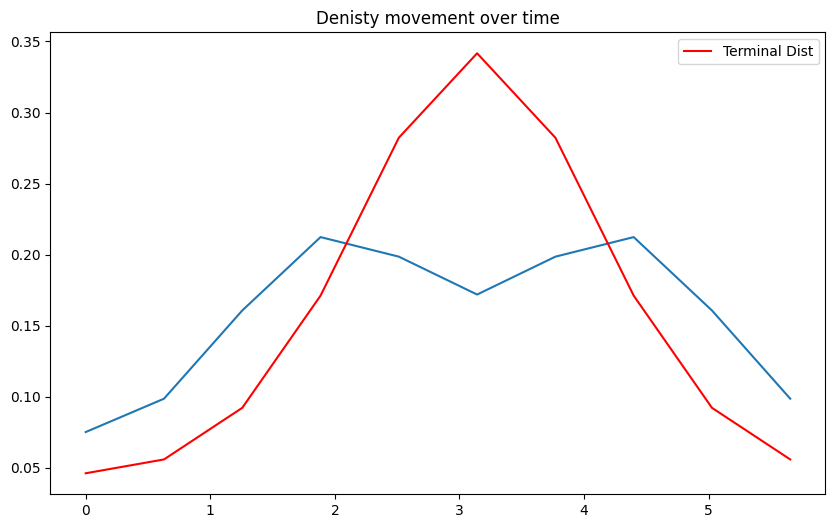

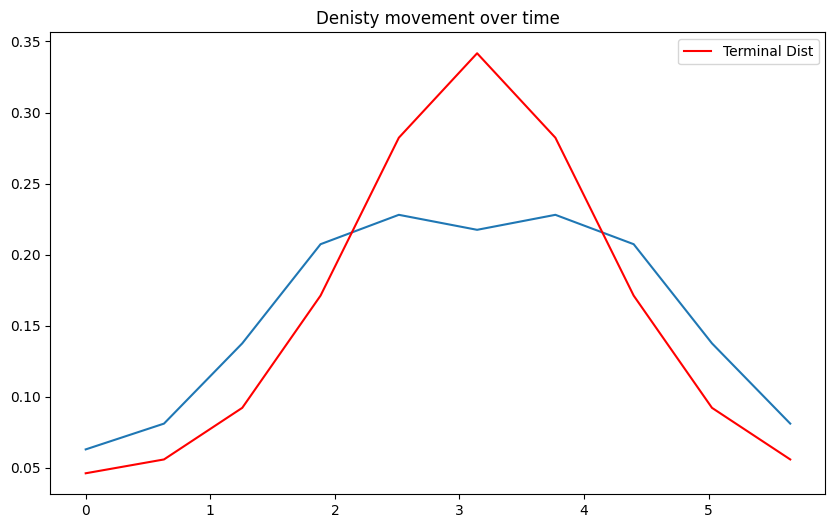

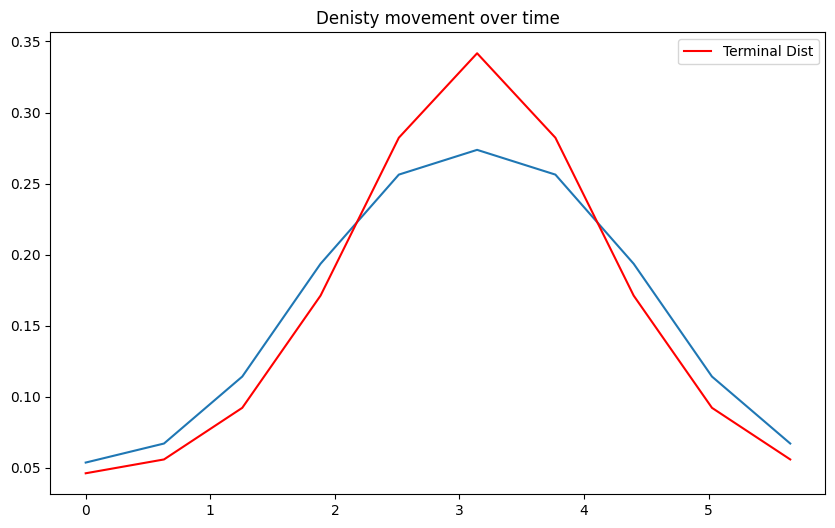

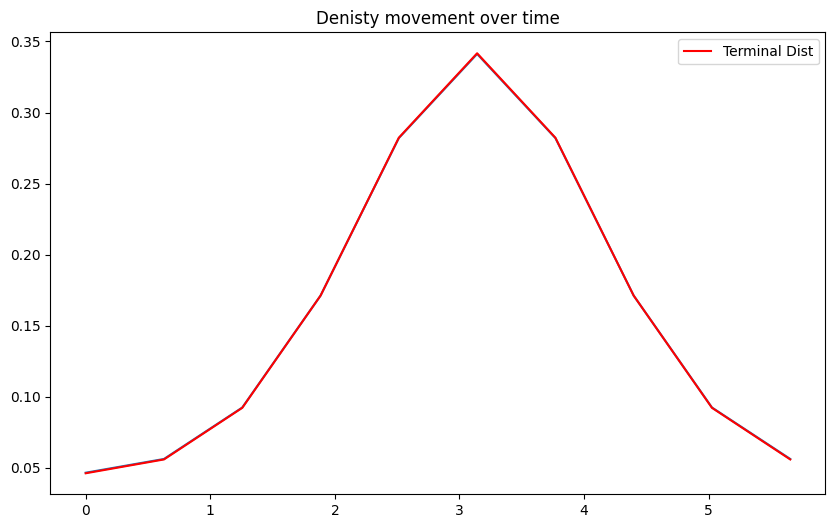

In [25]:
T = 10
N = 10

xs = np.arange(0, 2*np.pi, 2*np.pi/N)
p1 = von_mises_pdf(xs, 0, 1)
p2 = np.roll(p1, 5)
wfr, p, v, z = dynamic_wfr_relaxed_grid_scipy(p1, p2, delta=1, rel=2, T=T)

# Plotting

for time_step in range(p.shape[0]):
    plt.figure(figsize=(10, 6))
    plt.plot(xs, p[time_step])
    plt.plot(xs, p2, color='r', label = 'Terminal Dist')
    plt.title('Denisty movement over time')
    plt.legend()
    plt.show()